In [1]:
import torch
from torch_geometric.datasets import Planetoid
from hivegraph.contrastive.grace import GRACE
from sklearn.linear_model import LogisticRegression
from util import * 
from torch_geometric.utils import to_dense_adj
import torch_geometric.transforms as T 
from augmentation import *
from query_strategies import *
import matplotlib.pyplot as plt


c:\Users\banfi\anaconda3\envs\graph_active\Lib\site-packages\torch_geometric\typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] A megadott eljárás nem található
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [2]:
data_splits = [torch.load(f"data_splits\\cora_splits\\split_{i}.pt") for i in range(10)]
dataset_o = data_splits[0].to('cuda')

C:\Users\banfi\AppData\Local\Temp\ipykernel_3120\983164769.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_splits = [torch.load(f"data_splits\\cora_splits\\split_{i

In [3]:
device = 'cuda'

In [4]:
model = GRACE(num_features=dataset_o.num_features,hidden=128, num_layers=2, drop_edge_rate_1=0.3,drop_edge_rate_2=0.3,drop_feature_rate_1=0.3,drop_feature_rate_2=0.3).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.01)

In [5]:
dataset_o.contrastive_validation_mask = dataset_o.val_mask
dataset_o.contrastive_train_mask = ~dataset_o.val_mask

In [6]:
for epoch in range(500):
    opt.zero_grad()
    loss = model.train_step(dataset_o.x,dataset_o.edge_index)
    print(loss)
    loss.backward()
    opt.step()

tensor(8.5762, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.5535, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.9936, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.3360, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.9769, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.6880, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.5482, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.4917, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.3516, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.4108, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.3462, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.3441, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.3333, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.3006, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.2783, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.2613, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.2707, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.2340, device='cuda:0',

In [7]:
out = model(dataset_o.x,dataset_o.edge_index)

In [8]:
DROPOUT= 0.3
NUM_PASSES = 10
BUDGET = 150
EPOCHS = 100
SIGNIFICANCE_ITERATIONS = 10

NOISE_PROB = 0.4
NOISE_LEVEL = 1.0

In [9]:
# Augmentations
drop_edge = DropEdge(DROPOUT)
noise_feature_all = NoiseFeature(NOISE_LEVEL, 1)
noise_feature_col = NoiseFeature(NOISE_LEVEL, NOISE_PROB, "col")
noise_feature_row = NoiseFeature(NOISE_LEVEL, NOISE_PROB, "row")
noise_latent = NoiseLatent(NOISE_LEVEL)
mask_feature = MaskFeature(DROPOUT)

drop_edge_noise_all = T.Compose([drop_edge, noise_feature_all])
drop_edge_noise_col = T.Compose([drop_edge, noise_feature_col])
drop_edge_noise_row = T.Compose([drop_edge, noise_feature_row])
drop_edge_mask_feature = T.Compose([drop_edge, mask_feature])

In [10]:
# AUGMENTED ENTROPY
dataset = dataset_o.clone()
acc_aug = []
for b in range(BUDGET):
    pool_indices = get_mask_indices(dataset.train_pool).cpu()

    predictor = LogisticRegression()
    predictor.fit(out[dataset.train_mask].detach().cpu().numpy(), dataset.y[dataset.train_mask].detach().cpu().numpy())
    acc = predictor.score(out[dataset.test_mask].detach().cpu().numpy(), dataset.y[dataset.test_mask].detach().cpu().numpy())

    entropy_sum = torch.zeros(dataset.num_nodes)
    
    for _ in range(NUM_PASSES):
        data_tmp = dataset.clone()
        data_tmp = drop_edge_noise_all(data_tmp)
        out_c = model(data_tmp.x, data_tmp.edge_index)
        pred_log_probas = predictor.predict_log_proba(out_c.detach().cpu().numpy())
        entropies = calculate_entropy(torch.tensor(pred_log_probas))
        entropy_sum += entropies
        
    pred_log_probas = predictor.predict_log_proba(out.detach().cpu().numpy())
    entropy_o = calculate_entropy(torch.tensor(pred_log_probas))
    entropy_sum +=entropy_o
    entropy_sum /= NUM_PASSES
    
    
    
    
    
    chosen_node_ix = torch.argmax(entropy_sum[pool_indices])
    chosen_node = pool_indices[chosen_node_ix]
    dataset.train_pool[chosen_node] = False
    dataset.train_mask[chosen_node] = True
    
    predictor = LogisticRegression()
    acc_aug.append(acc)
    print(f"Budget {b} - Accuracy: {acc}")

Budget 0 - Accuracy: 0.333
Budget 1 - Accuracy: 0.379
Budget 2 - Accuracy: 0.525
Budget 3 - Accuracy: 0.568
Budget 4 - Accuracy: 0.535
Budget 5 - Accuracy: 0.56
Budget 6 - Accuracy: 0.568
Budget 7 - Accuracy: 0.572
Budget 8 - Accuracy: 0.597
Budget 9 - Accuracy: 0.545
Budget 10 - Accuracy: 0.552
Budget 11 - Accuracy: 0.569
Budget 12 - Accuracy: 0.545
Budget 13 - Accuracy: 0.478
Budget 14 - Accuracy: 0.486
Budget 15 - Accuracy: 0.464
Budget 16 - Accuracy: 0.509
Budget 17 - Accuracy: 0.506
Budget 18 - Accuracy: 0.529
Budget 19 - Accuracy: 0.537
Budget 20 - Accuracy: 0.538
Budget 21 - Accuracy: 0.538
Budget 22 - Accuracy: 0.551
Budget 23 - Accuracy: 0.543
Budget 24 - Accuracy: 0.536
Budget 25 - Accuracy: 0.556
Budget 26 - Accuracy: 0.598
Budget 27 - Accuracy: 0.589
Budget 28 - Accuracy: 0.613
Budget 29 - Accuracy: 0.62
Budget 30 - Accuracy: 0.6
Budget 31 - Accuracy: 0.605
Budget 32 - Accuracy: 0.611
Budget 33 - Accuracy: 0.613
Budget 34 - Accuracy: 0.64
Budget 35 - Accuracy: 0.638
Budget 

In [11]:
out.shape

torch.Size([2708, 128])

In [12]:
out_n = out.detach()

In [13]:
def predict_log_proba_sklearn_model(model, x):
    out = x @ model.coef_.T + model.intercept_
    out = torch.tensor(out)
    return torch.nn.functional.log_softmax(out, dim=1)

In [14]:
class PredictorWrapper():
    def __init__(self, model):
        self.weights = torch.tensor(model.coef_.T, dtype=torch.float32).cuda()
        self.weights.requires_grad = False
        self.bias = torch.tensor(model.intercept_, dtype=torch.float32).cuda()
        self.bias.requires_grad = False
    def predict_log_proba(self, x):
        out =  x @ self.weights + self.bias
        return torch.nn.functional.log_softmax(out, dim=1)

In [15]:
# LATENT NOISE

dataset = dataset_o.clone()
acc_laten_noise_o = []
out_a = out.clone()
for b in range(BUDGET):
    pool_indices = get_mask_indices(dataset.train_pool).cpu()

    predictor = LogisticRegression()
    predictor.fit(out[dataset.train_mask].detach().cpu().numpy(), dataset.y[dataset.train_mask].detach().cpu().numpy())
    acc = predictor.score(out[dataset.test_mask].detach().cpu().numpy(), dataset.y[dataset.test_mask].detach().cpu().numpy())

    entropy_sum = torch.zeros(dataset.num_nodes)
    
    for _ in range(NUM_PASSES):
        out_c = out_a + noise_latent(out_a)
        pred_log_probas = predictor.predict_log_proba(out_c.detach().cpu().numpy())
        entropies = calculate_entropy(torch.tensor(pred_log_probas))
        entropy_sum += entropies
    entropy_sum /= NUM_PASSES
    
    chosen_node_ix = torch.argmax(entropy_sum[pool_indices])
    chosen_node = pool_indices[chosen_node_ix]
    dataset.train_pool[chosen_node] = False
    dataset.train_mask[chosen_node] = True
    
    acc_laten_noise_o.append(acc)
    print(f"Budget {b} - Accuracy: {acc}")

Budget 0 - Accuracy: 0.333
Budget 1 - Accuracy: 0.378
Budget 2 - Accuracy: 0.385
Budget 3 - Accuracy: 0.412
Budget 4 - Accuracy: 0.518
Budget 5 - Accuracy: 0.462
Budget 6 - Accuracy: 0.461
Budget 7 - Accuracy: 0.482
Budget 8 - Accuracy: 0.563
Budget 9 - Accuracy: 0.596
Budget 10 - Accuracy: 0.586
Budget 11 - Accuracy: 0.598
Budget 12 - Accuracy: 0.609
Budget 13 - Accuracy: 0.638
Budget 14 - Accuracy: 0.67
Budget 15 - Accuracy: 0.677
Budget 16 - Accuracy: 0.672
Budget 17 - Accuracy: 0.675
Budget 18 - Accuracy: 0.652
Budget 19 - Accuracy: 0.661
Budget 20 - Accuracy: 0.659
Budget 21 - Accuracy: 0.643
Budget 22 - Accuracy: 0.643
Budget 23 - Accuracy: 0.646
Budget 24 - Accuracy: 0.645
Budget 25 - Accuracy: 0.664
Budget 26 - Accuracy: 0.678
Budget 27 - Accuracy: 0.676
Budget 28 - Accuracy: 0.667
Budget 29 - Accuracy: 0.671
Budget 30 - Accuracy: 0.68
Budget 31 - Accuracy: 0.683
Budget 32 - Accuracy: 0.684
Budget 33 - Accuracy: 0.689
Budget 34 - Accuracy: 0.689
Budget 35 - Accuracy: 0.692
Budg

In [16]:
# ENTROPY
dataset = dataset_o.clone()
acc_entropy = []
for b in range(BUDGET):
    predictor = LogisticRegression()
    predictor.fit(out[dataset.train_mask].detach().cpu().numpy(), dataset.y[dataset.train_mask].detach().cpu().numpy())
    
    acc = predictor.score(out[dataset.test_mask].detach().cpu().numpy(), dataset.y[dataset.test_mask].detach().cpu().numpy())
    pred_log_probas = predictor.predict_log_proba(out.detach().cpu().numpy())
    entropies = calculate_entropy(torch.tensor(pred_log_probas))
    pool_indices = get_mask_indices(dataset.train_pool).cpu()
    chosen_node_ix = torch.argmax(entropies[pool_indices])
    chosen_node = pool_indices[chosen_node_ix]
    dataset.train_pool[chosen_node] = False
    dataset.train_mask[chosen_node] = True
    predictor = LogisticRegression()
    acc_entropy.append(acc)
    print(f"Budget {b} - Accuracy: {acc}")
    

Budget 0 - Accuracy: 0.333
Budget 1 - Accuracy: 0.373
Budget 2 - Accuracy: 0.43
Budget 3 - Accuracy: 0.436
Budget 4 - Accuracy: 0.47
Budget 5 - Accuracy: 0.509
Budget 6 - Accuracy: 0.53
Budget 7 - Accuracy: 0.5
Budget 8 - Accuracy: 0.493
Budget 9 - Accuracy: 0.531
Budget 10 - Accuracy: 0.547
Budget 11 - Accuracy: 0.563
Budget 12 - Accuracy: 0.65
Budget 13 - Accuracy: 0.596
Budget 14 - Accuracy: 0.608
Budget 15 - Accuracy: 0.604
Budget 16 - Accuracy: 0.61
Budget 17 - Accuracy: 0.597
Budget 18 - Accuracy: 0.584
Budget 19 - Accuracy: 0.592
Budget 20 - Accuracy: 0.583
Budget 21 - Accuracy: 0.608
Budget 22 - Accuracy: 0.633
Budget 23 - Accuracy: 0.637
Budget 24 - Accuracy: 0.634
Budget 25 - Accuracy: 0.671
Budget 26 - Accuracy: 0.704
Budget 27 - Accuracy: 0.689
Budget 28 - Accuracy: 0.696
Budget 29 - Accuracy: 0.712
Budget 30 - Accuracy: 0.711
Budget 31 - Accuracy: 0.718
Budget 32 - Accuracy: 0.71
Budget 33 - Accuracy: 0.711
Budget 34 - Accuracy: 0.714
Budget 35 - Accuracy: 0.706
Budget 36 

In [17]:
# LATENT DISTANCE
BUDGET = 150
dataset = dataset_o.clone()
acc_latent = []
for b in range(BUDGET):
    
    predictor = LogisticRegression()
    predictor.fit(out[dataset.train_mask].detach().cpu().numpy(), dataset.y[dataset.train_mask].detach().cpu().numpy())
    acc = predictor.score(out[dataset.test_mask].detach().cpu().numpy(), dataset.y[dataset.test_mask].detach().cpu().numpy())
    
    pool_indices = get_mask_indices(dataset.train_pool).cpu()

    dist_matrix = torch.cdist(out[dataset.train_pool], out[dataset.train_pool])
    adj = to_dense_adj(dataset.edge_index)[0][dataset.train_pool][:,dataset.train_pool]
    adj = adj.cuda()
    dist_matrix = dist_matrix * adj
    
    
    max_dist = dist_matrix.mean(dim=1)
    min_max_dist = torch.argmin(max_dist)
    chosen_node = pool_indices[min_max_dist]

    
    dataset.train_pool[chosen_node] = False
    dataset.train_mask[chosen_node] = True
    # predictor = LogisticRegression()
    acc_latent.append(acc)
    print(f"Budget {b} - Accuracy: {acc}")

Budget 0 - Accuracy: 0.333
Budget 1 - Accuracy: 0.284
Budget 2 - Accuracy: 0.454
Budget 3 - Accuracy: 0.459
Budget 4 - Accuracy: 0.429
Budget 5 - Accuracy: 0.446
Budget 6 - Accuracy: 0.458
Budget 7 - Accuracy: 0.448
Budget 8 - Accuracy: 0.466
Budget 9 - Accuracy: 0.466
Budget 10 - Accuracy: 0.463
Budget 11 - Accuracy: 0.457
Budget 12 - Accuracy: 0.454
Budget 13 - Accuracy: 0.455
Budget 14 - Accuracy: 0.475
Budget 15 - Accuracy: 0.475
Budget 16 - Accuracy: 0.48
Budget 17 - Accuracy: 0.48
Budget 18 - Accuracy: 0.51
Budget 19 - Accuracy: 0.511
Budget 20 - Accuracy: 0.5
Budget 21 - Accuracy: 0.492
Budget 22 - Accuracy: 0.489
Budget 23 - Accuracy: 0.489
Budget 24 - Accuracy: 0.488
Budget 25 - Accuracy: 0.477
Budget 26 - Accuracy: 0.481
Budget 27 - Accuracy: 0.468
Budget 28 - Accuracy: 0.498
Budget 29 - Accuracy: 0.51
Budget 30 - Accuracy: 0.51
Budget 31 - Accuracy: 0.526
Budget 32 - Accuracy: 0.515
Budget 33 - Accuracy: 0.536
Budget 34 - Accuracy: 0.548
Budget 35 - Accuracy: 0.55
Budget 36 

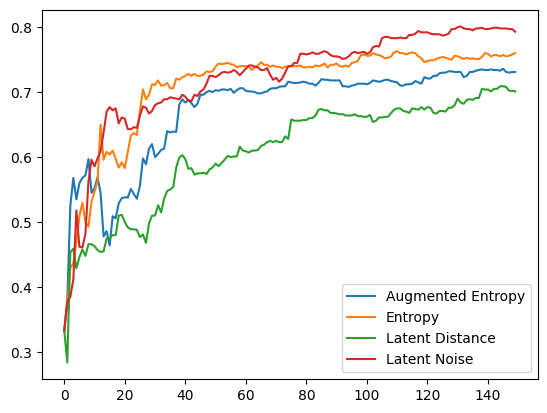

In [18]:

plt.plot(acc_aug, label="Augmented Entropy")
plt.plot(acc_entropy, label="Entropy")
plt.plot(acc_latent, label="Latent Distance")
# plt.plot(acc_laten_noise, label="Latent Noise ADV")
plt.plot(acc_laten_noise_o, label="Latent Noise")
plt.legend()
plt.show()